In [6]:
!date

Tue Apr  8 02:13:32 PM EDT 2025


In [7]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [8]:
import ants
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [9]:
from sklearn.decomposition import PCA
from sklearn import linear_model

In [24]:
indir = '../Data/StudyForrest/fmriprep/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
ofn = os.path.join('../Data/StudyForrest/CompCor-maps-forrest','{sub}-COMPCOR-objectcategories_run-{r}.nii.gz')

cf_fn =  os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')

subs = subs_orig
subs.sort()
print(f'{len(subs)}/{len(subs_orig)}')

14/14


 36%|███▌      | 5/14 [01:30<02:44, 18.28s/it]<ipython-input-25-16ad48f1a317>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,5))
100%|██████████| 14/14 [07:09<00:00, 30.64s/it]


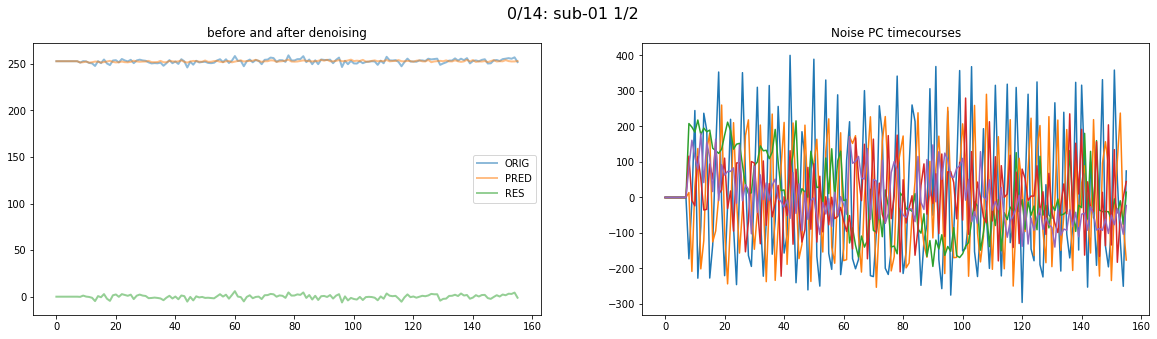

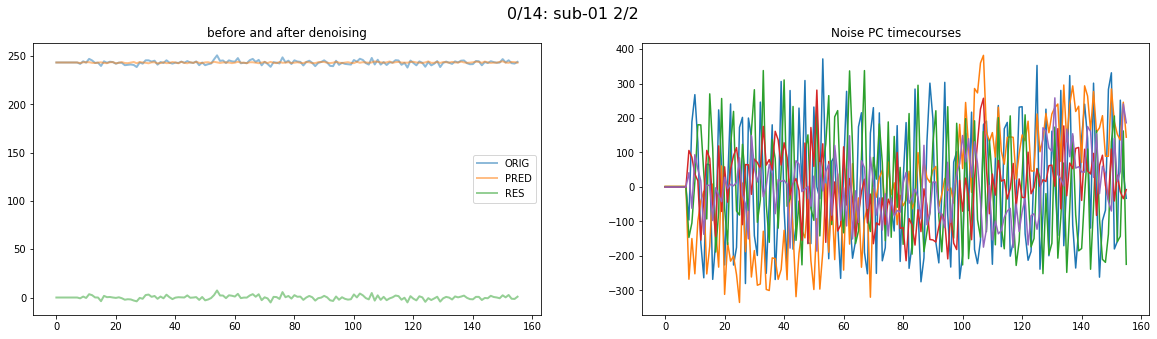

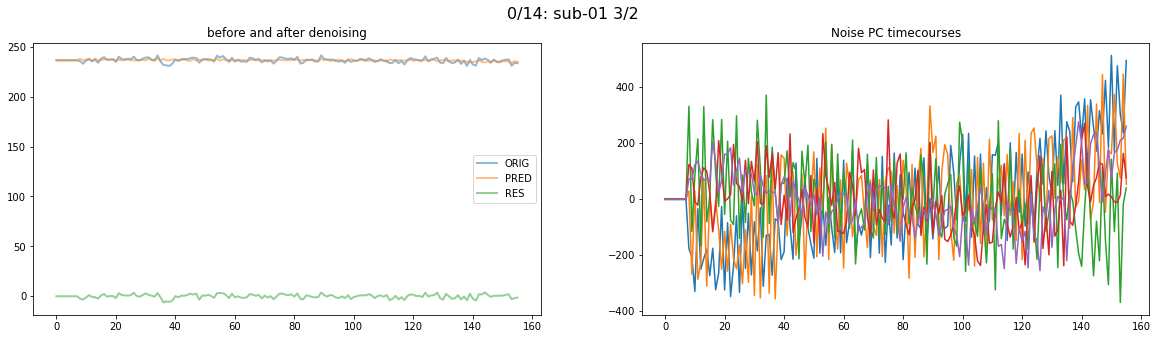

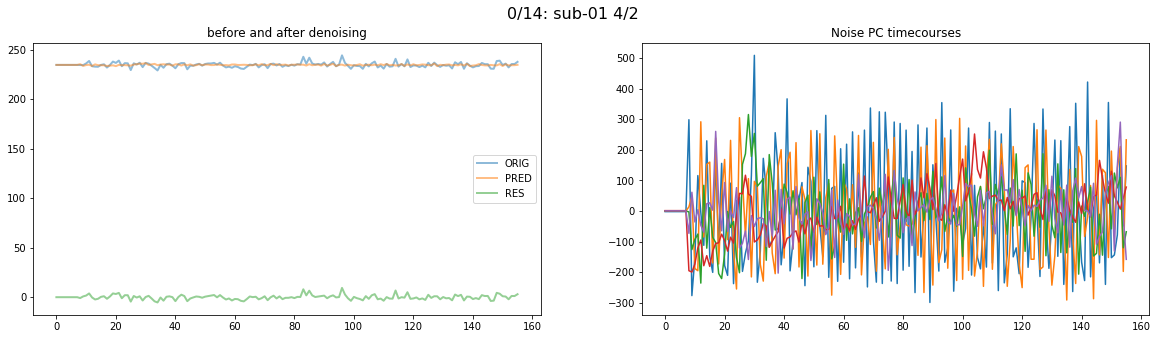

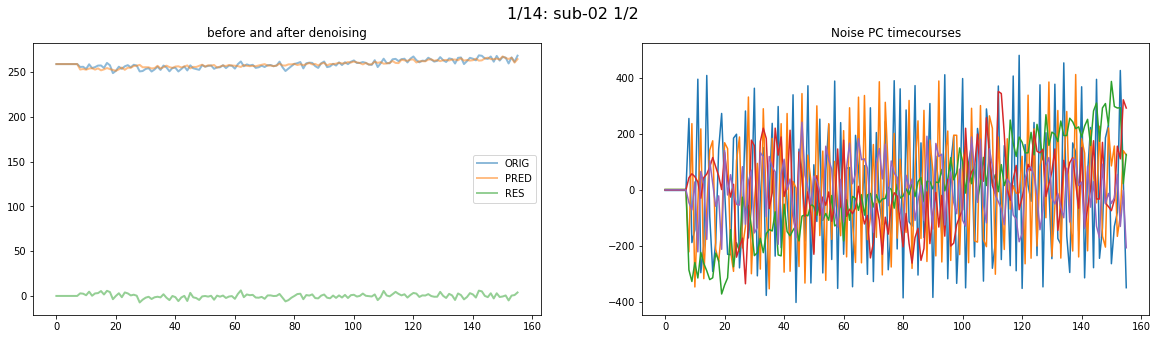

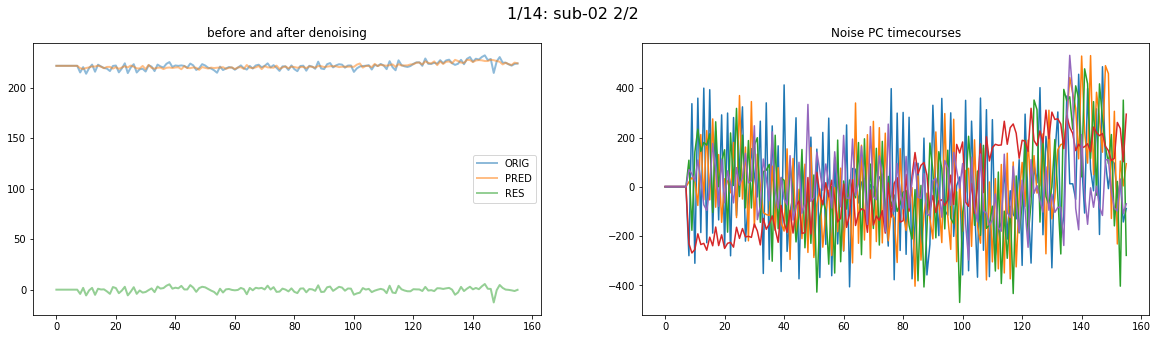

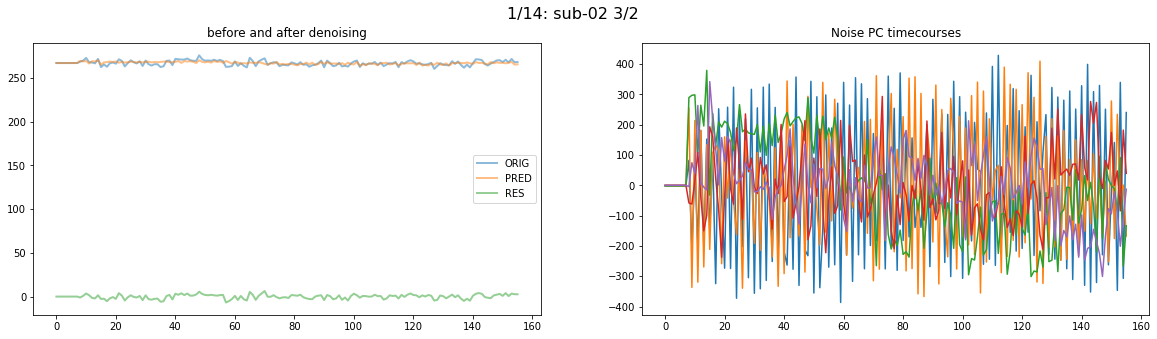

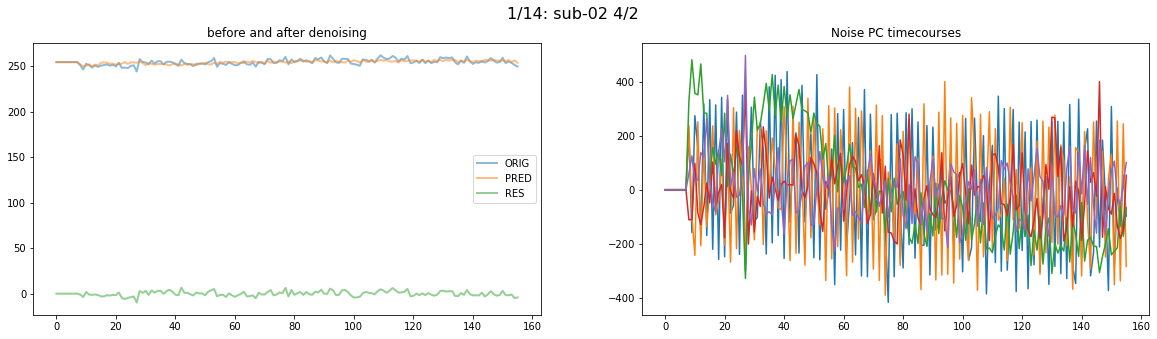

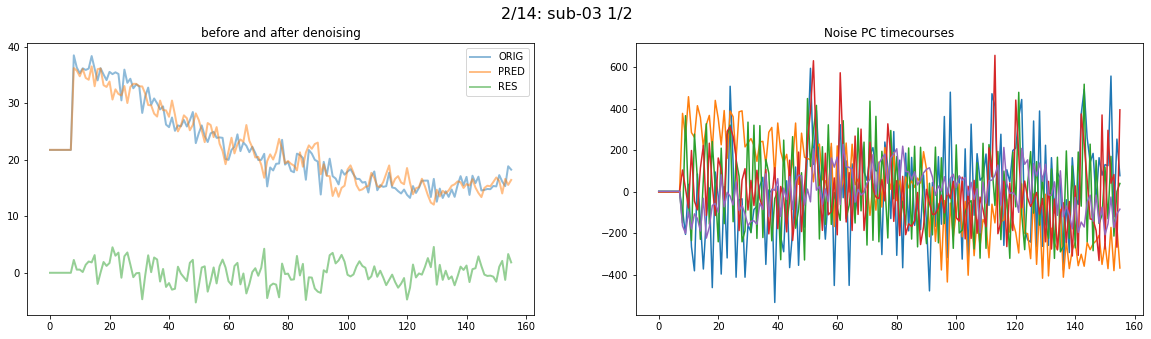

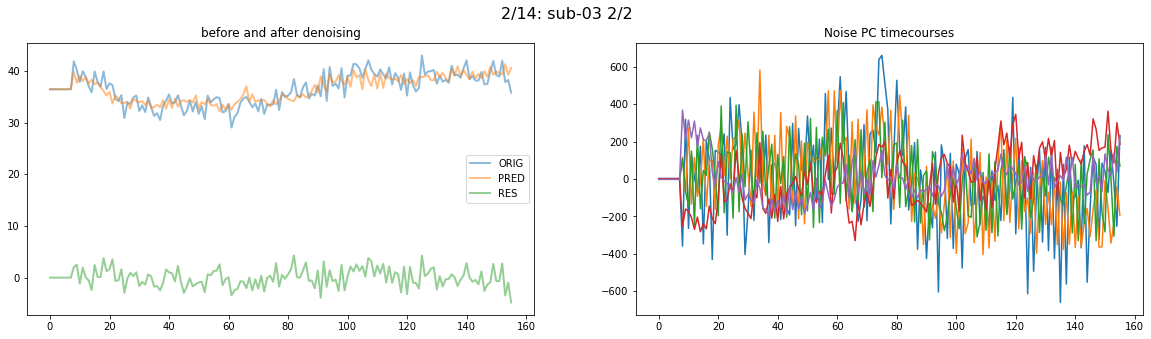

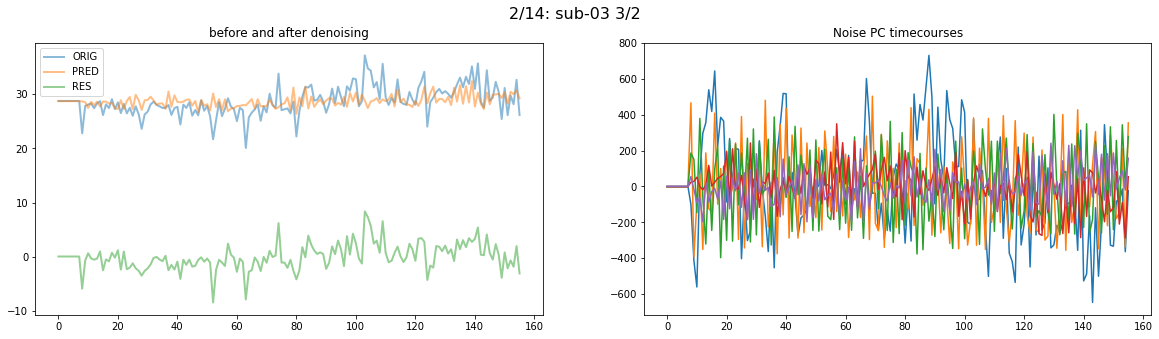

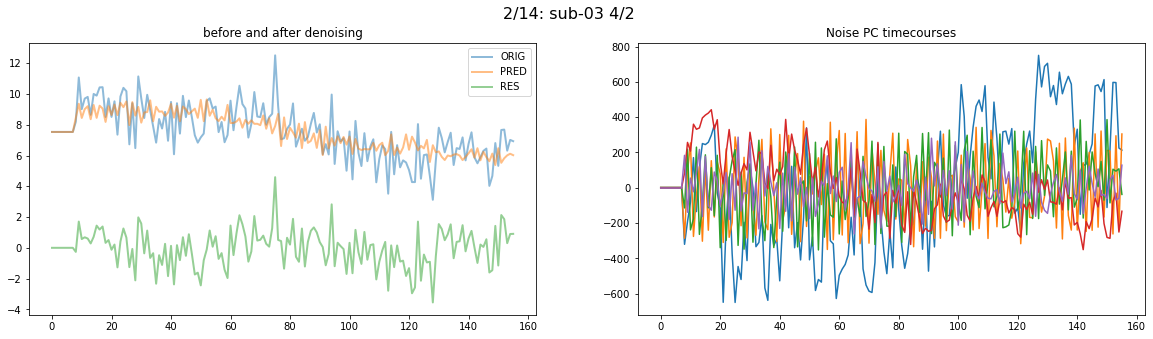

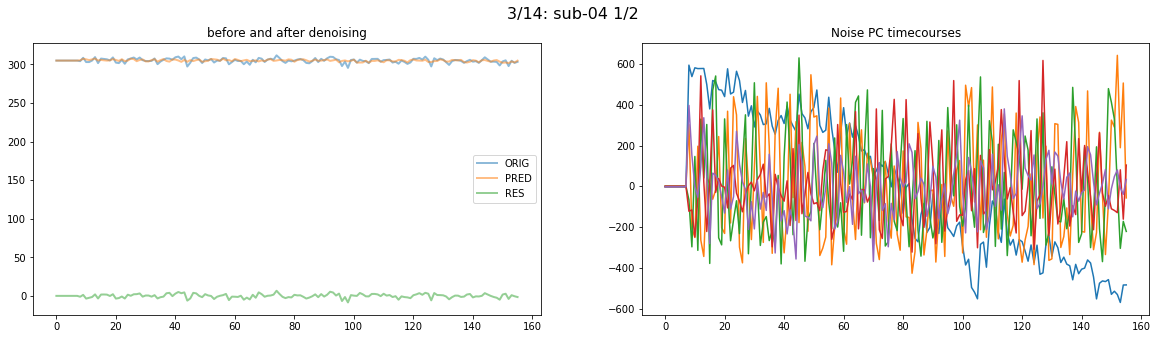

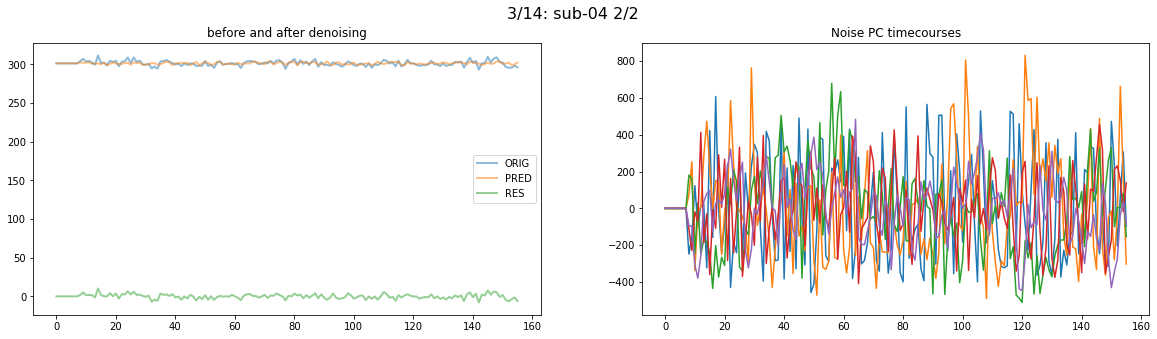

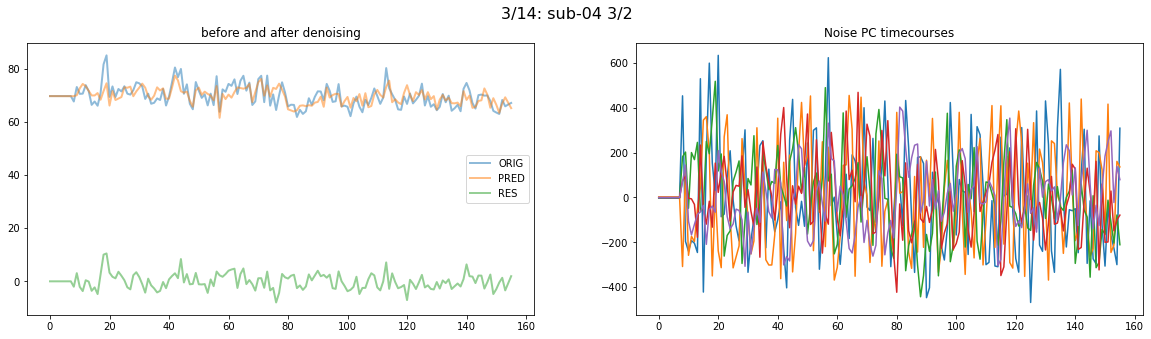

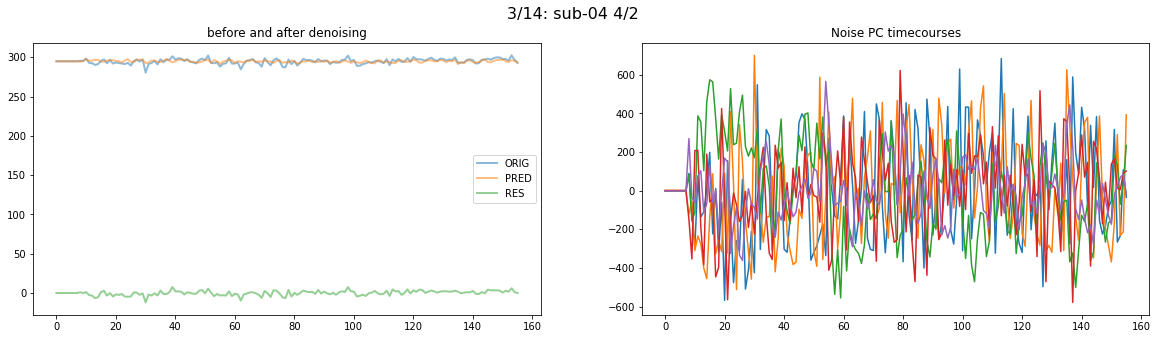

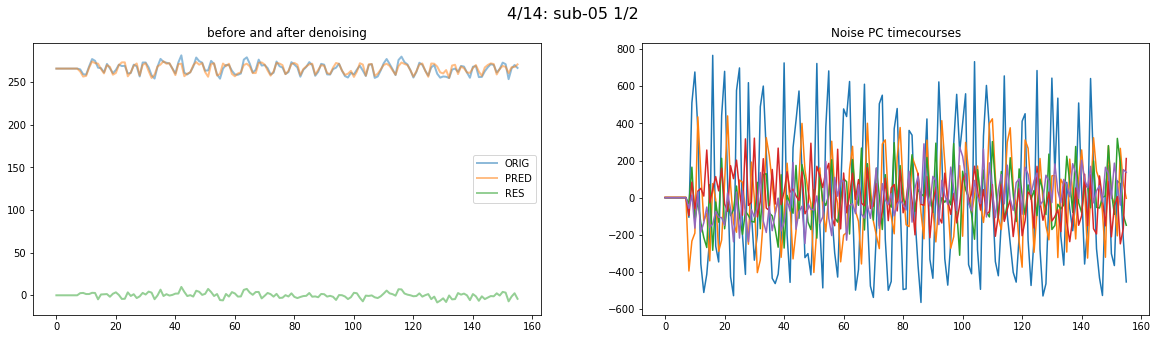

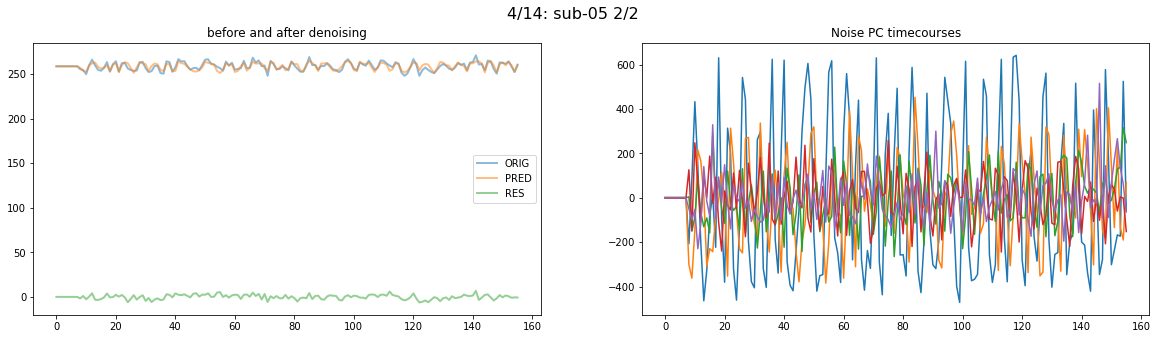

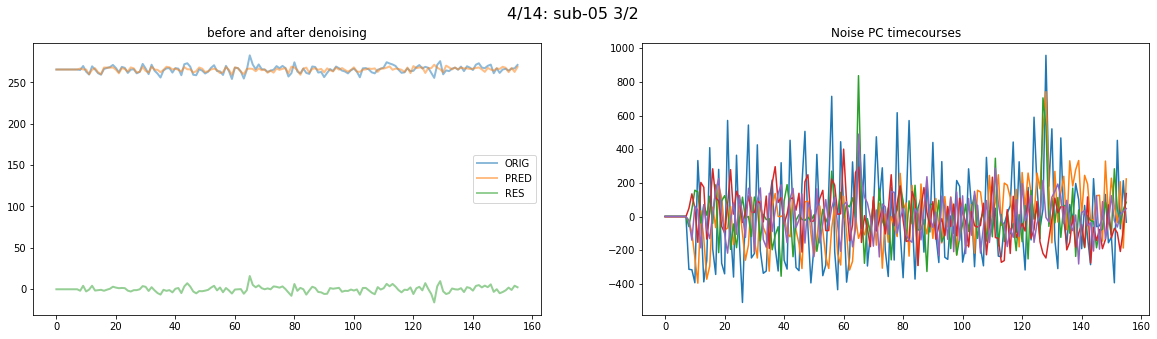

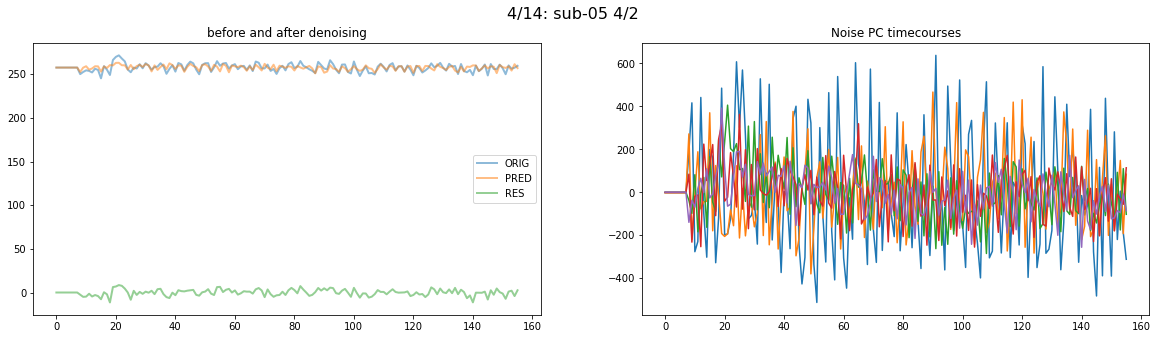

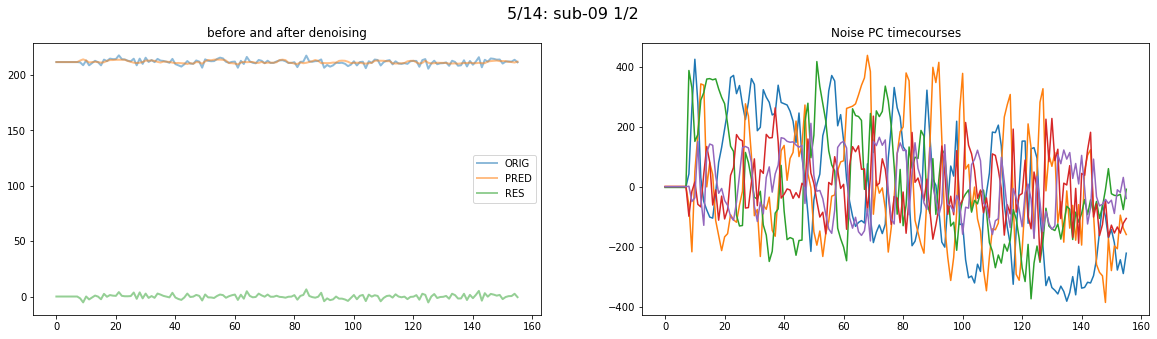

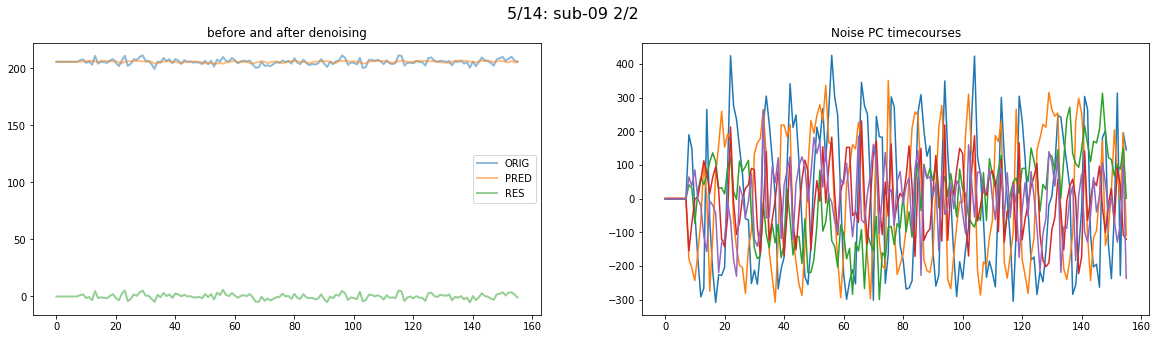

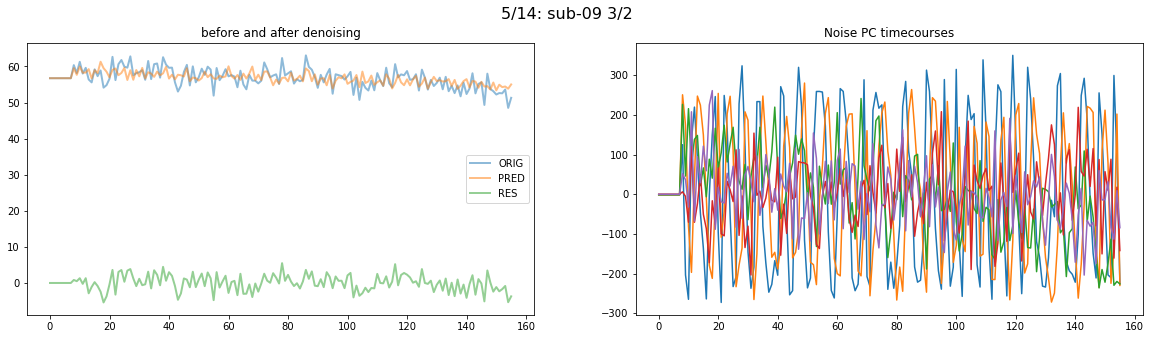

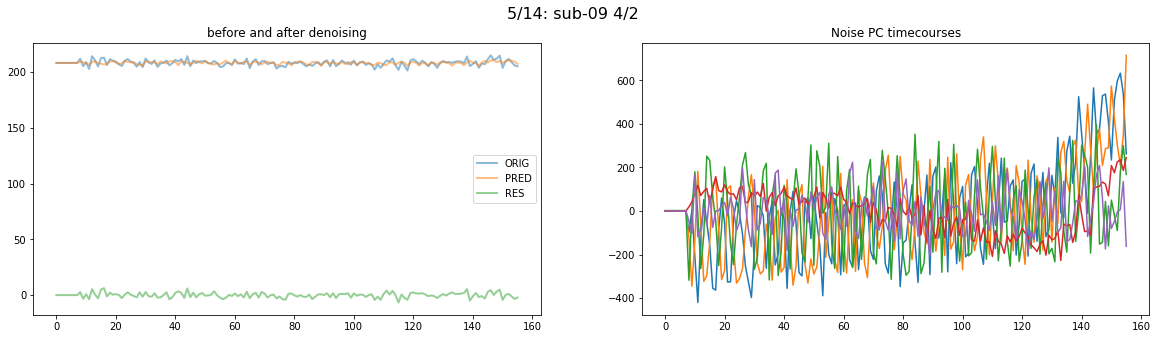

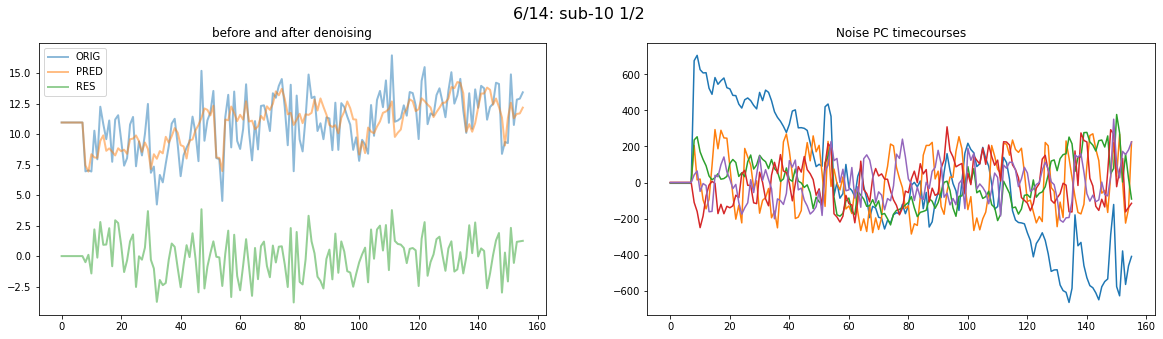

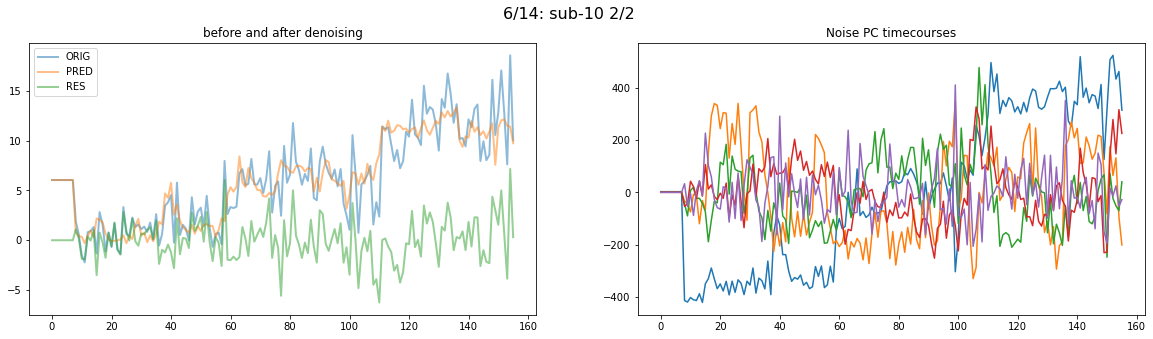

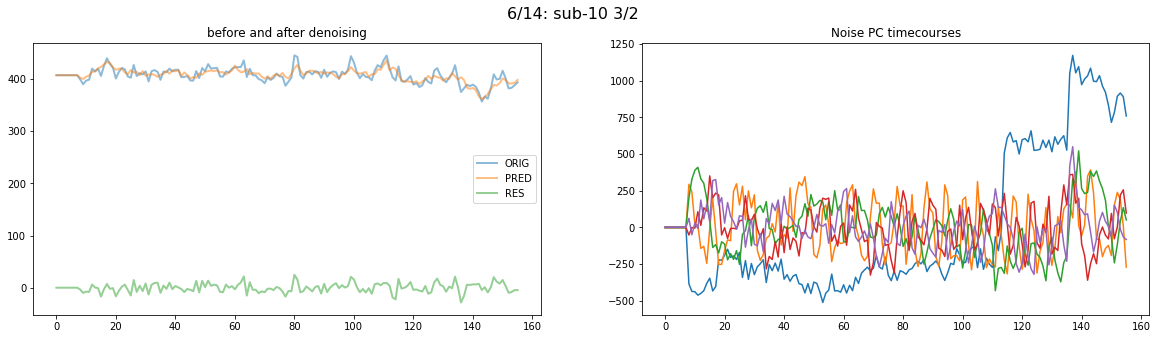

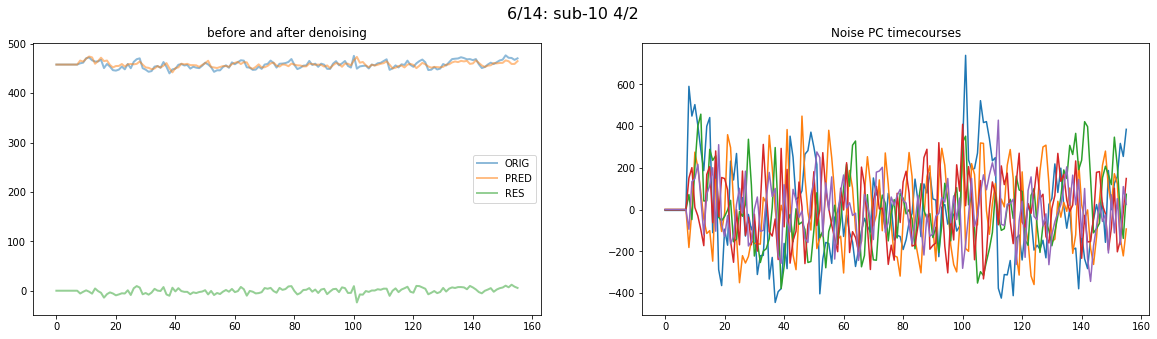

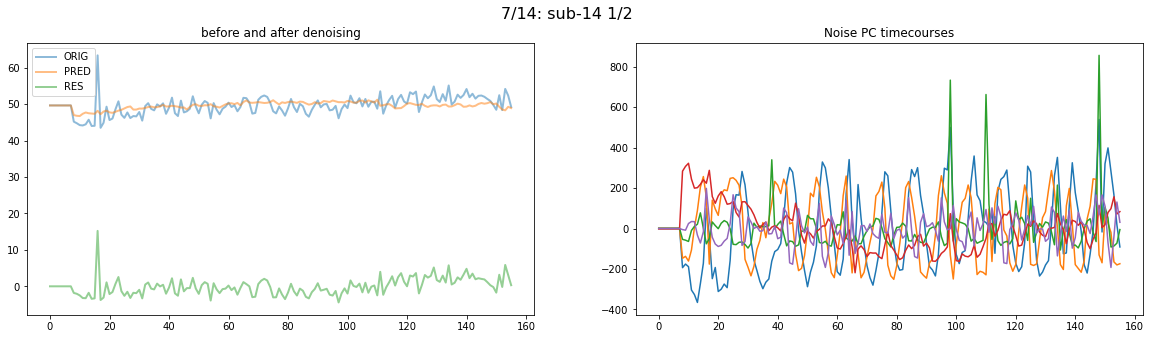

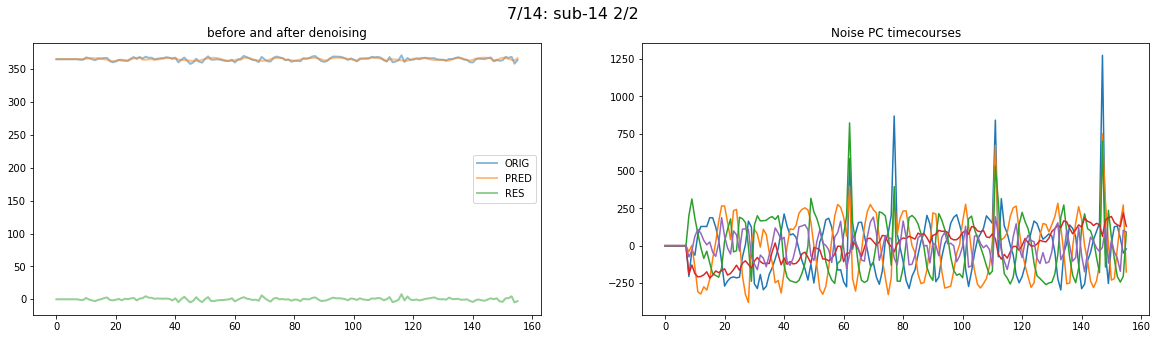

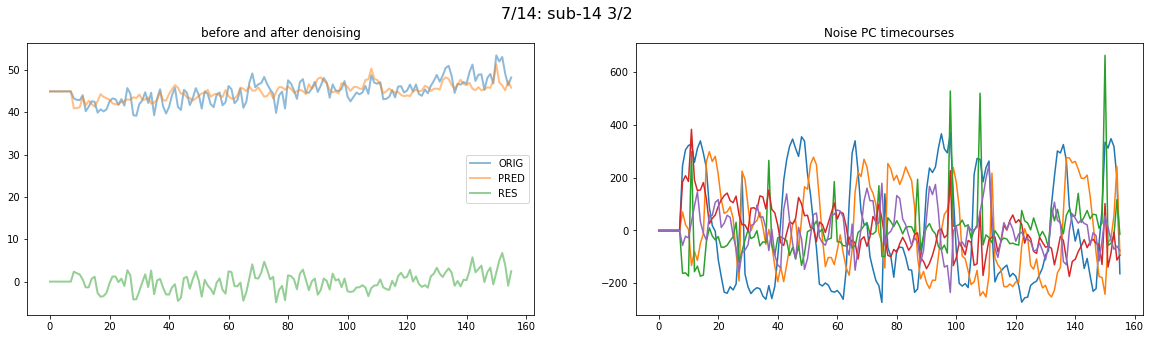

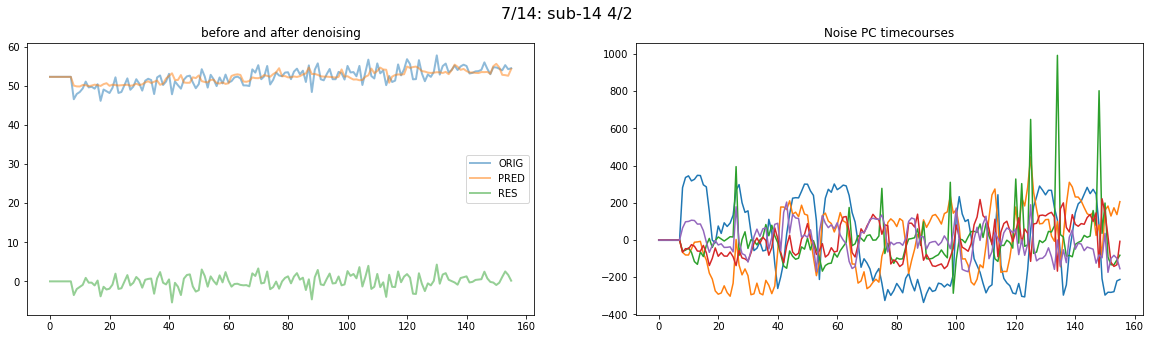

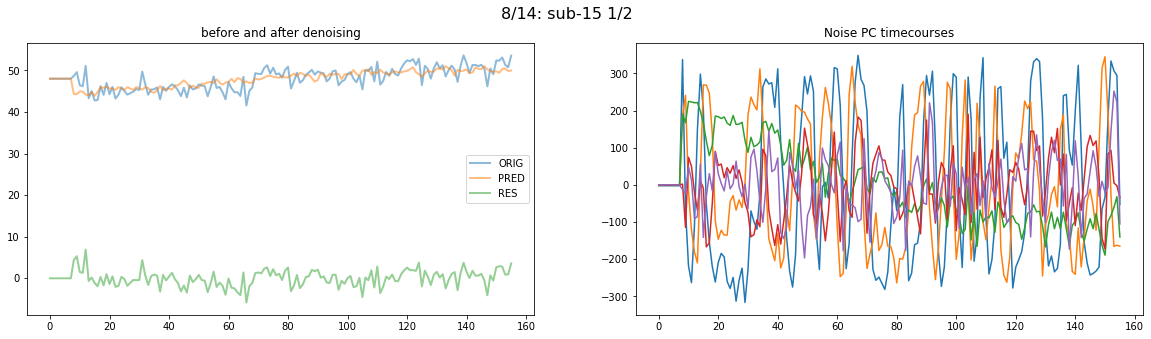

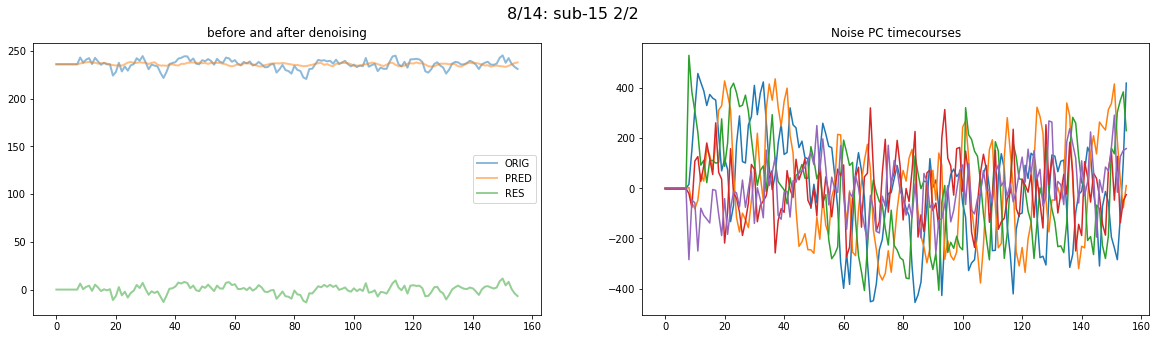

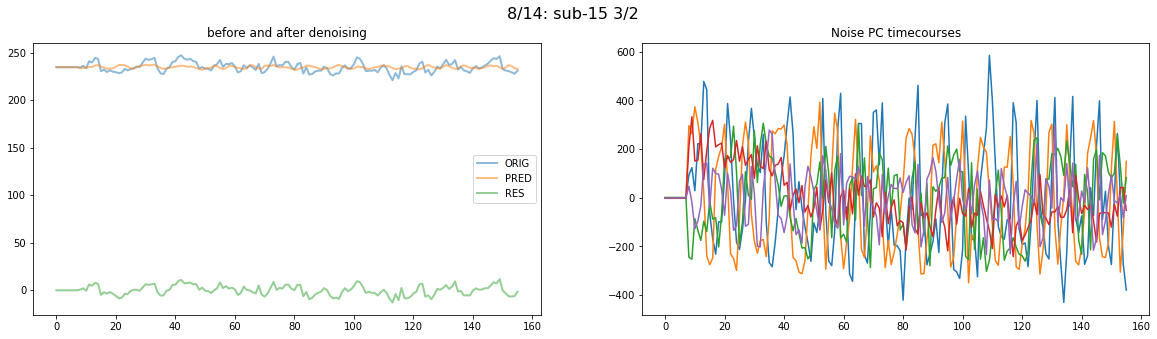

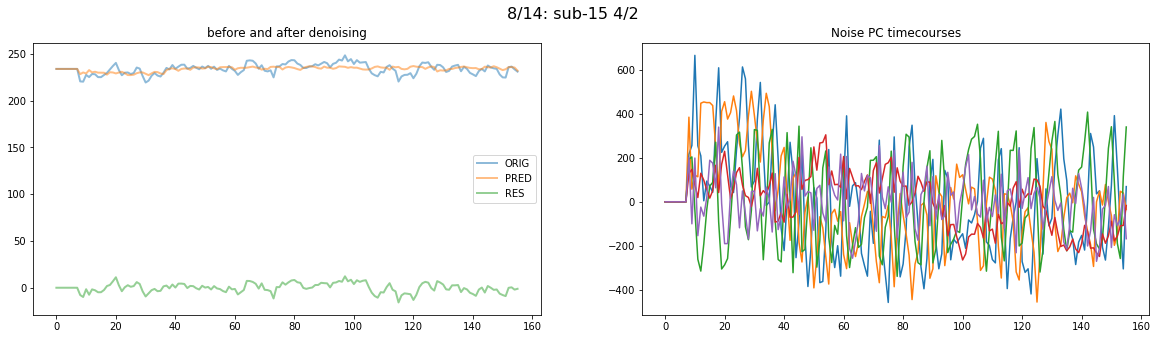

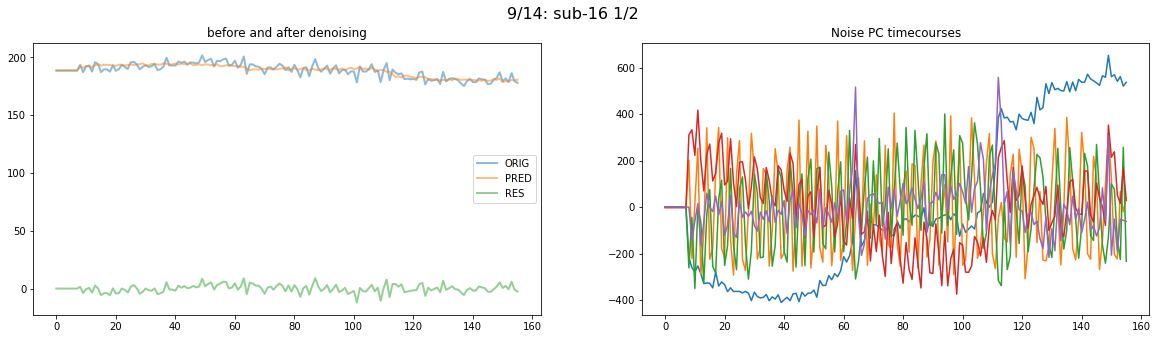

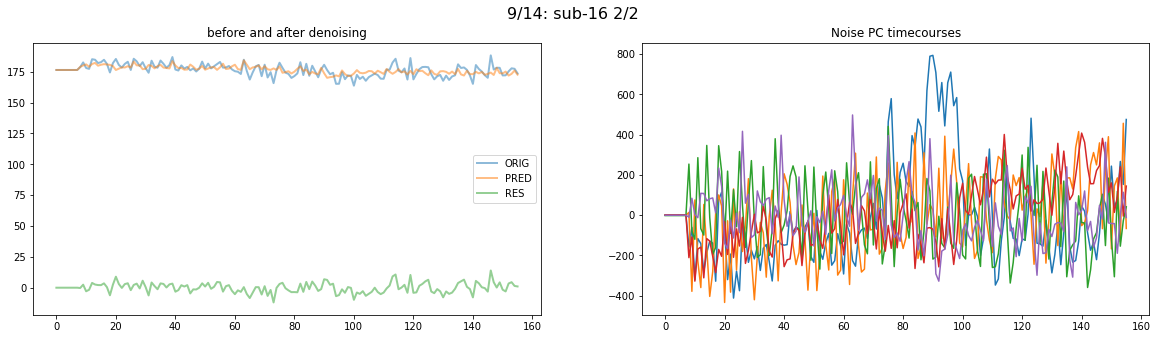

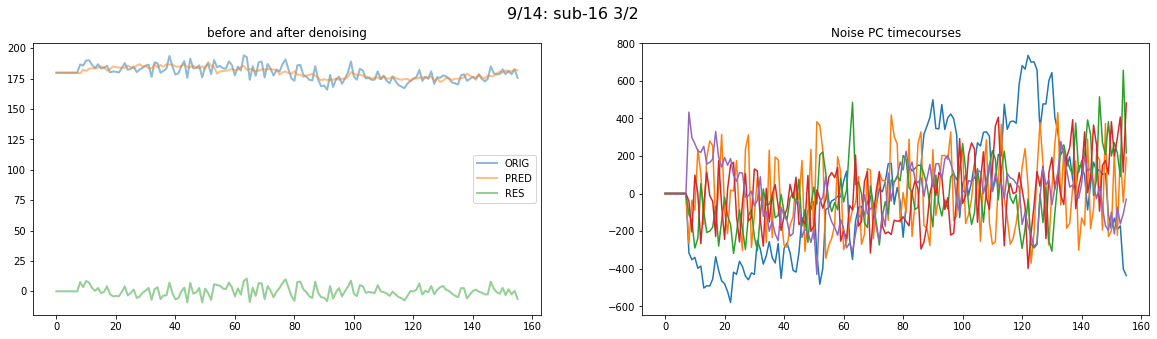

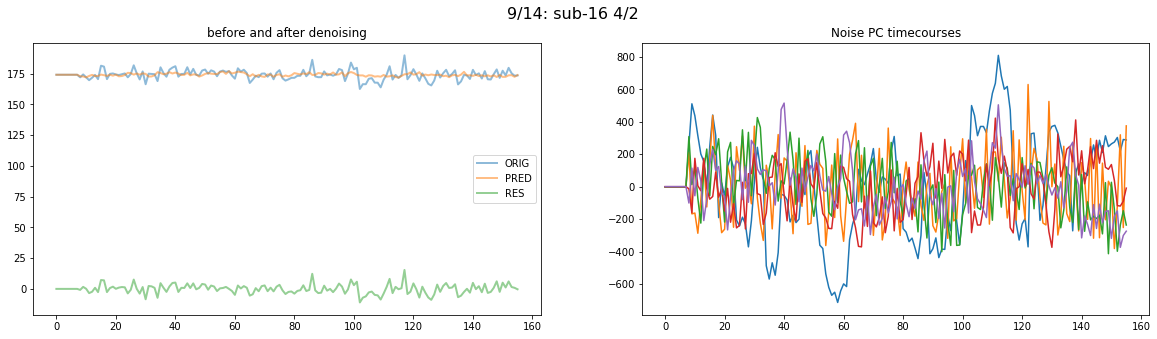

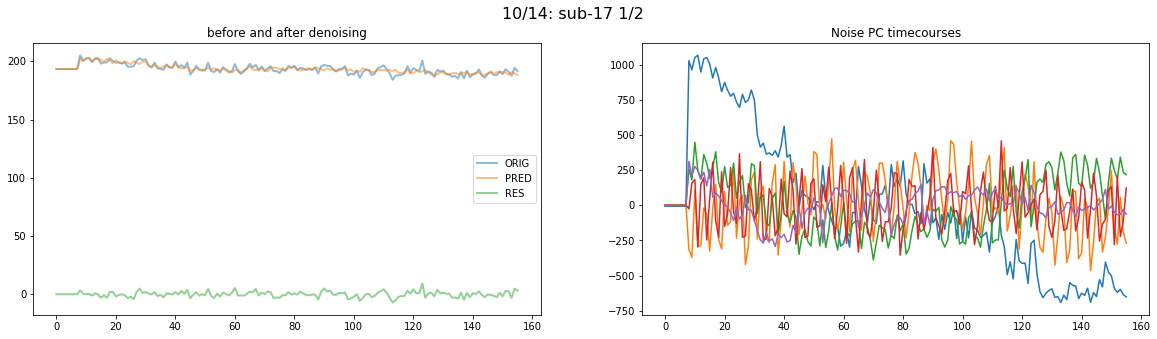

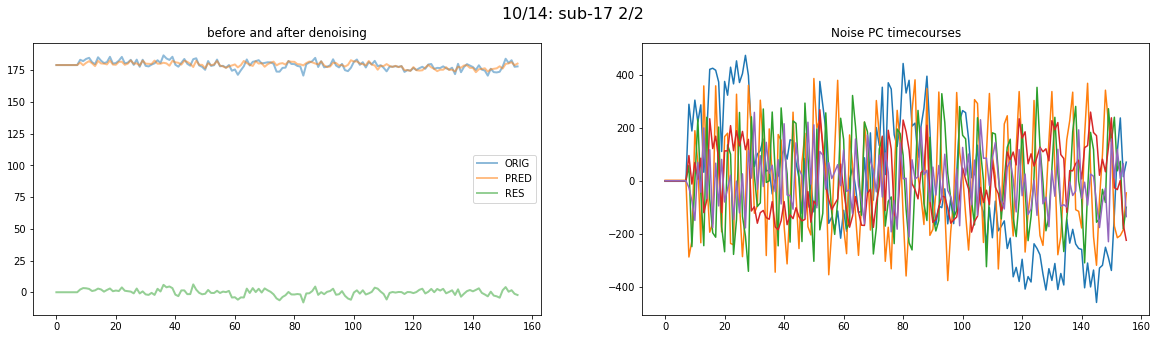

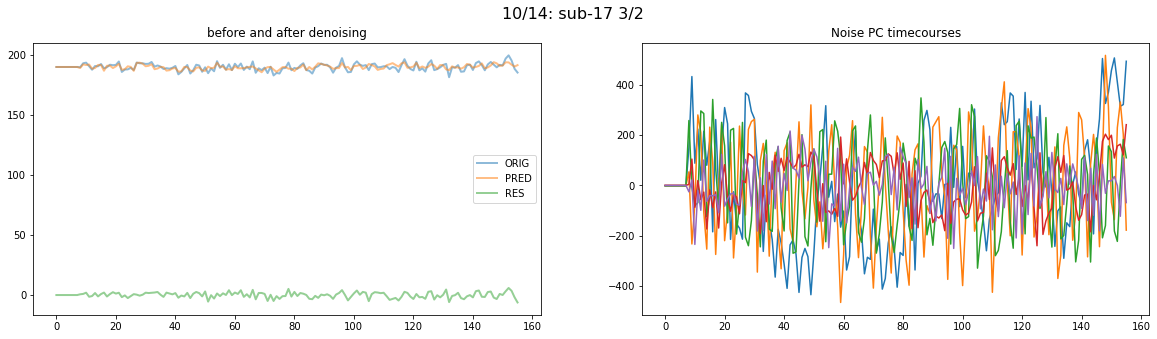

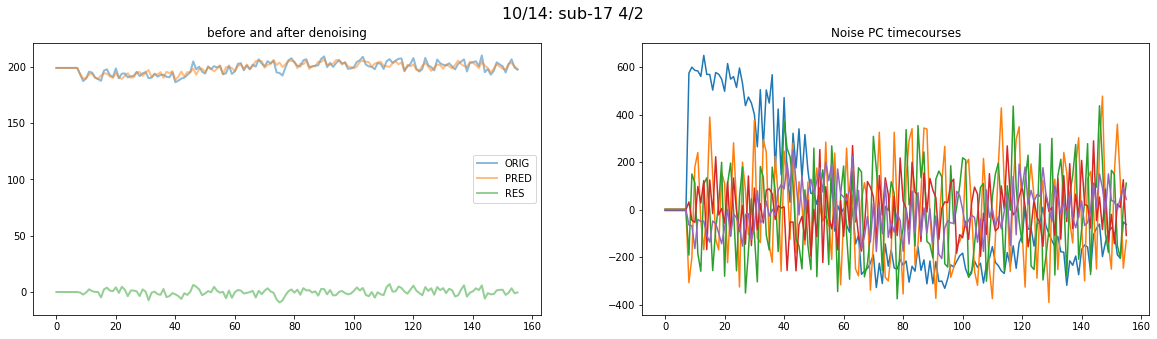

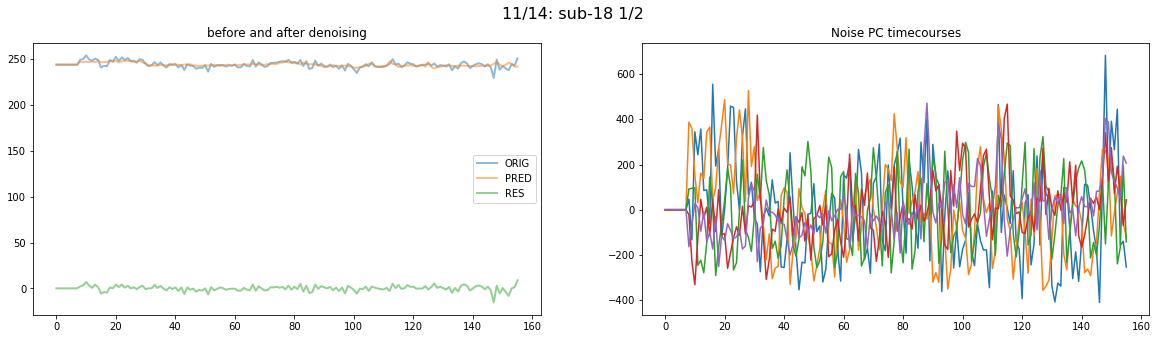

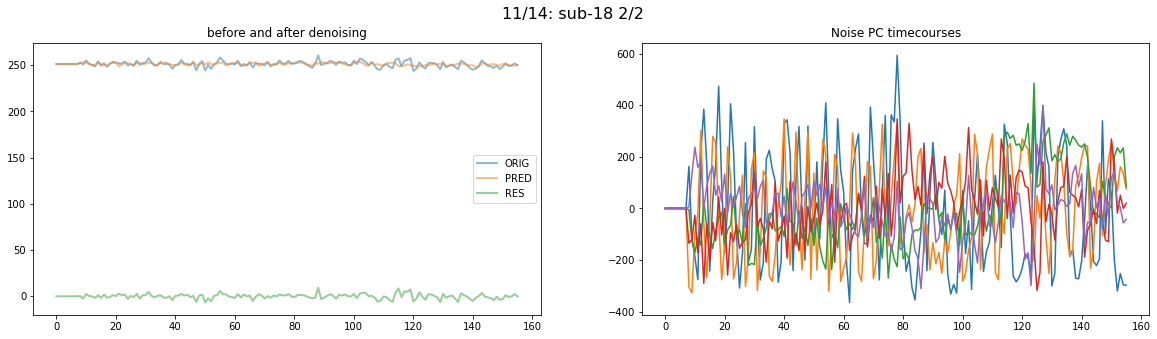

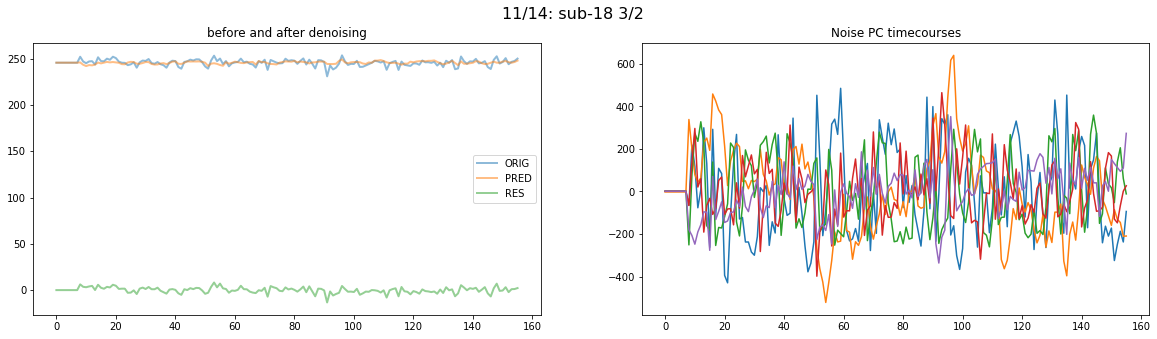

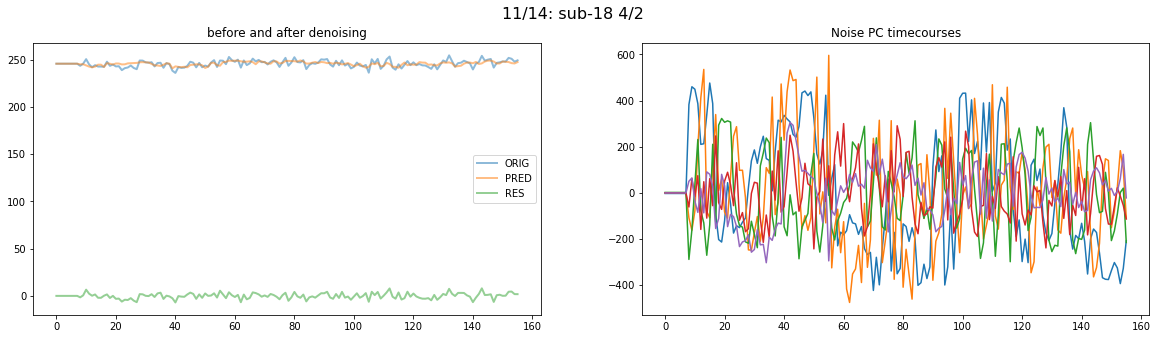

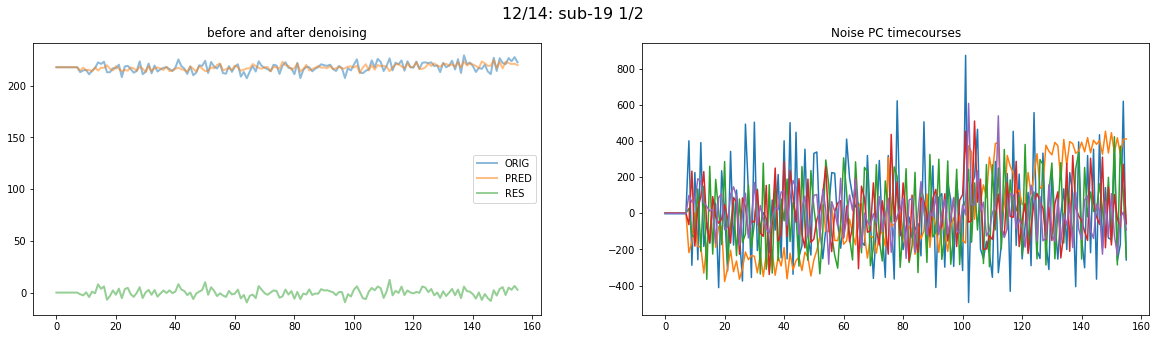

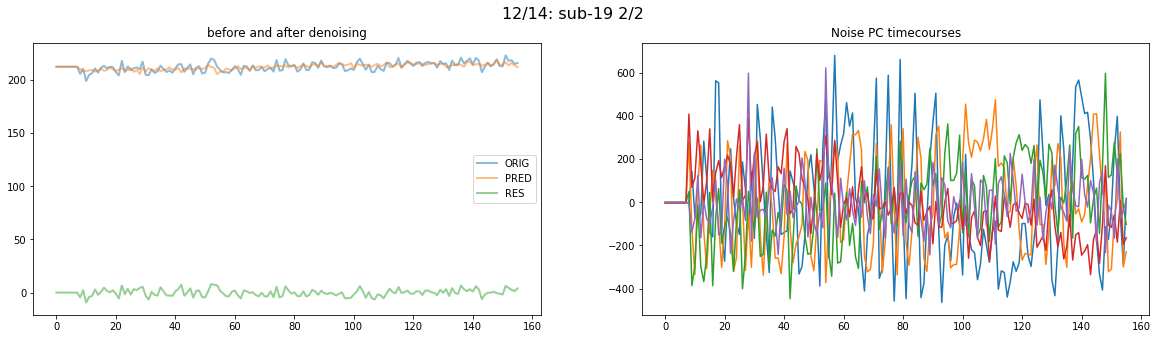

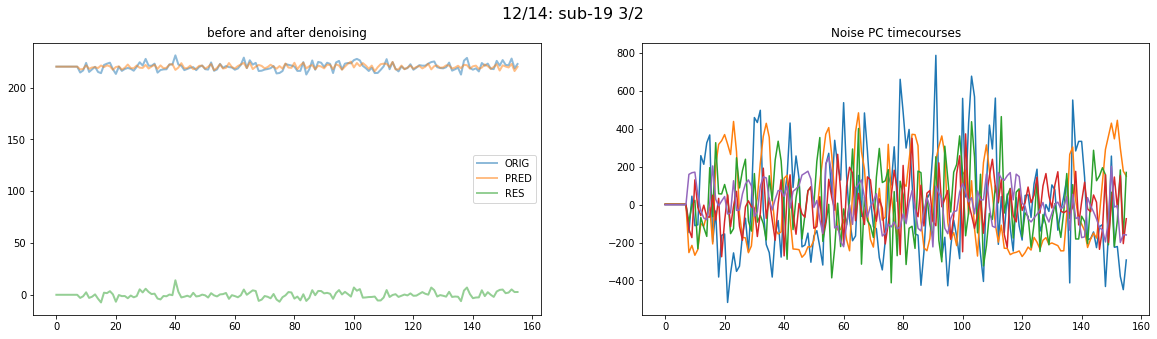

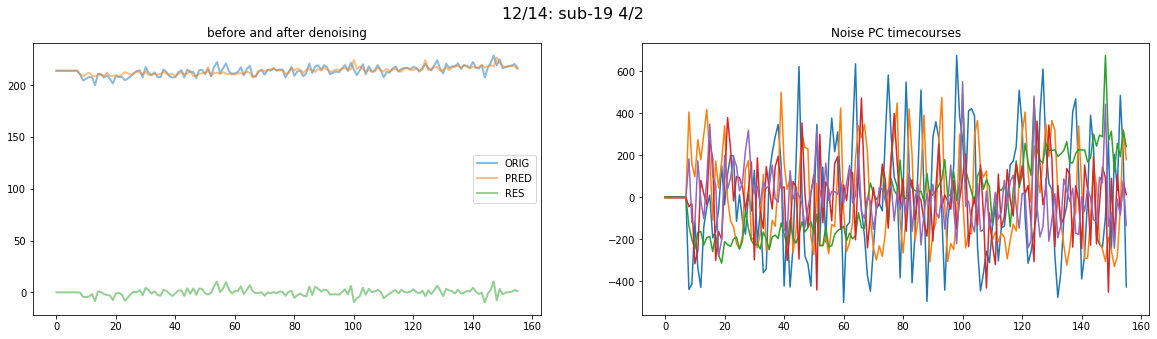

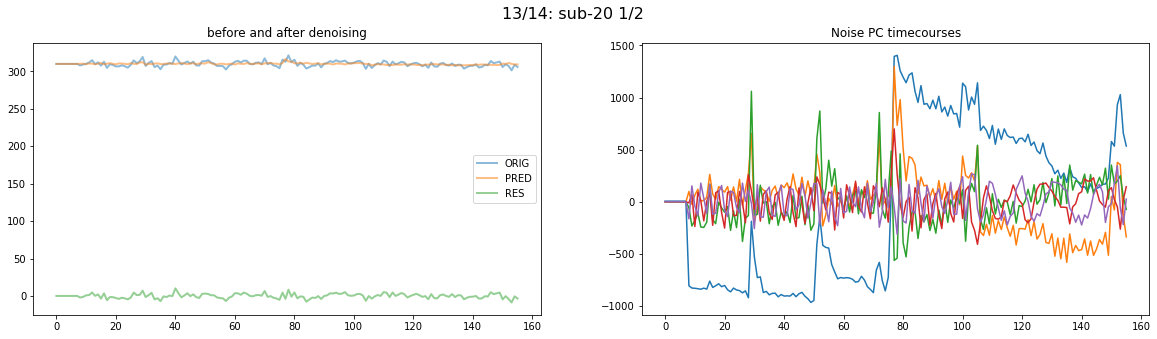

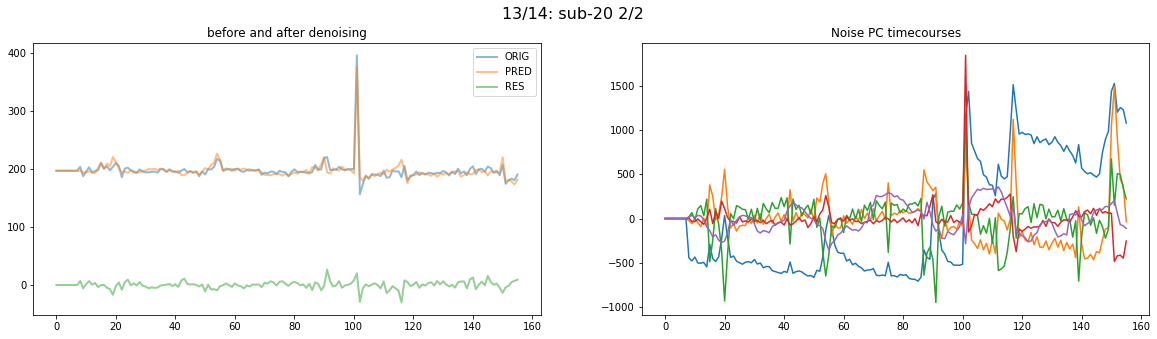

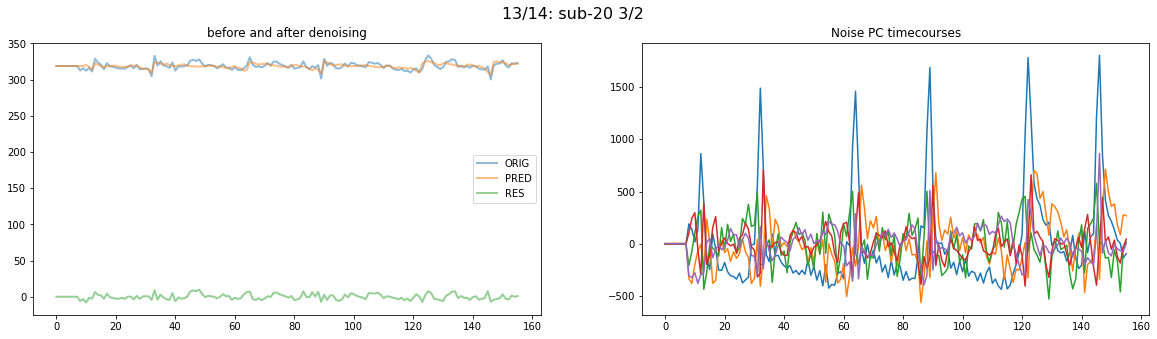

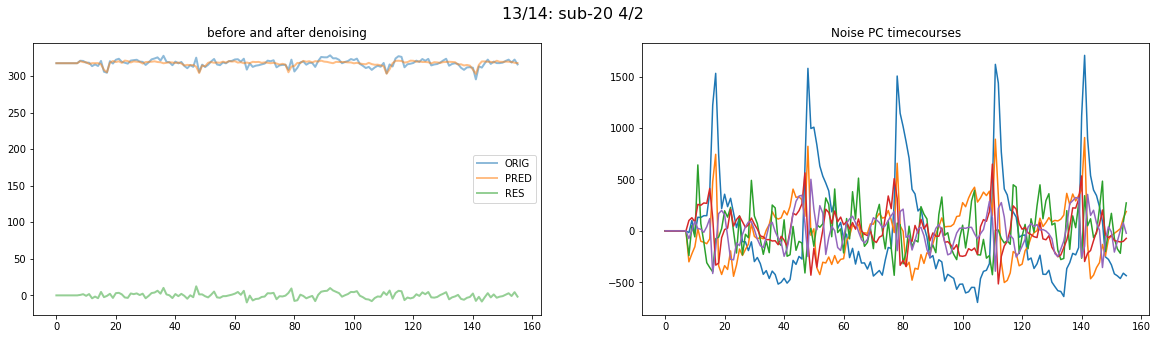

In [25]:
for s in tqdm(range(len(subs))):
    sub = subs[s]
    
    gm = ants.image_read(gm_fn.format(sub=sub))
    cf = ants.image_read(cf_fn.format(sub=sub))
    
    for r in [1,2,3,4]:
        epi = ants.image_read(epi_fn.format(sub=sub,r=r))
        
        nt = epi.shape[-1] # Number of timepoints
        
        ndummy = 8 # how many dummies to discard
        
        epi_flat = epi.numpy().reshape(-1,nt).transpose() # (370, 1082035)
        epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
        #gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
        gm_flat = gm.numpy().flatten() # (1082035,)
        gm_flat[gm_flat<.5]=0
        gm_flat[gm_flat>=.5]=1
        gm_flat = gm_flat.astype(int)
        cf_flat = cf.numpy().flatten().astype(int) # (1082035,)
        #print(epi_flat.shape)
        #print(gm_flat.shape)
        #print(cf_flat.shape)
        
        assert max(np.unique(cf_flat+gm_flat))!=2, 'overlap' # Check for overlap again
        
        cf_pcs = PCA(n_components = 5).fit_transform(epi_flat[:,cf_flat==1]) # (370, 5)
        lin_reg = linear_model.LinearRegression();
        lin_reg.fit(cf_pcs,epi_flat[:,gm_flat==1]);
        predicted = lin_reg.predict(cf_pcs)
        residuals = epi_flat[:,gm_flat==1]-predicted
        
        do_plot = True
        if do_plot==True:
            plt.figure(figsize=(20,5))
            plt.subplot(1,2,1)
            v = 500
            plt.plot(epi_flat[:,gm_flat==1][:,v],alpha=.5,linewidth=2)
            plt.plot(predicted[:,v],alpha=.5,linewidth=2)
            plt.plot(residuals[:,v],alpha=.5,linewidth=2)
            plt.legend(['ORIG','PRED','RES'])
            plt.title('before and after denoising')
            
            plt.subplot(1,2,2)
            plt.plot(cf_pcs)
            plt.title('Noise PC timecourses')
            
            plt.suptitle(
                f'{s}/{len(subs)}: {sub} {r}/2',
            fontsize=16)
        
         
        denoised_flat = np.zeros(epi_flat.shape)
        denoised_flat[:,gm_flat==1]=residuals
        denoised_flat = denoised_flat+epi_flat.mean(axis=0) # Aesthetics
        denoised_mat = denoised_flat.transpose().reshape(epi.shape)
        denoised = epi.new_image_like(denoised_mat)
        denoised.to_filename(ofn.format(sub=sub,r=r))

In [11]:
# for s in tqdm(range(len(subs))):
#     sub = subs[s]
    
#     gm = ants.image_read(gm_fn.format(sub=sub))
#     cf = ants.image_read(cf_fn.format(sub=sub))
    
#     for r in [1,2]:
#         epi = ants.image_read(epi_fn.format(sub=sub,r=r))
        
#         nt = epi.shape[-1] # Number of timepoints
        
#         ndummy = 8 # how many dummies to discard
        
#         epi_flat = epi.numpy().reshape(-1,nt).transpose() # (370, 1082035)
#         epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
#         gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
#         cf_flat = cf.numpy().flatten().astype(int) # (1082035,)

In [12]:
# corr_vals = []
# for s in tqdm(range(len(subs))):
#     sub = subs[s]
    
#     gm = ants.image_read(gm_fn.format(sub=sub))
#     cf = ants.image_read(cf_fn.format(sub=sub))
    
#     #for r in [1,2]:
#     r = 1
#     epi = ants.image_read(epi_fn.format(sub=sub,r=r))
#     denoised = denoised = ants.image_read(epi_fn.format(sub=sub,r=r).replace('-preproc_bold.nii','-COMPCORR_bold.nii'))
    
#     nt = epi.shape[-1] # Number of timepoints
#     ndummy = 8 # how many dummies to discard
    
#     epi_flat = epi.numpy().reshape(-1,nt).transpose() # (370, 1082035)
#     epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
#     denoised_flat = denoised.numpy().reshape(-1,nt).transpose() # (370, 1082035)
#     gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
#     cf_flat = cf.numpy().flatten().astype(int) # (1082035,)
#     corr_val = np.array([np.corrcoef(epi_flat[:,gm_flat==1][:,v],denoised_flat[:,gm_flat==1][:,v])[0,1] for v in np.random.randint(low=0,high=gm_flat.sum(),size=100)])
#     corr_vals.append(corr_val)